<a href="https://colab.research.google.com/github/nitinranjansharma/EVA5B2/blob/main/s11/S11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR

from PIL import Image
from read_inputs import read_transform_inputs
from utility_fun import *
import matplotlib.pyplot as plt
from gradcam.visualize import VisualizeCam
from train import *
from lrtest.lr_range_test import LRRangeFinder
from lrtest.lr_cycle_plot import LRCyclePlot
from model.newmodel import NetCifar10

In [ ]:
trainset, trainloader, testset, testloader, classes = read_transform_inputs()

Files already downloaded and verified
Files already downloaded and verified


  cat plane  ship  frog


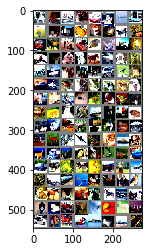

In [ ]:

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


In [ ]:
###Model Import
model = NetCifar10().to(device)
show_model_summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
        LayerBlock-4           [-1, 64, 32, 32]               0
            Conv2d-5          [-1, 128, 32, 32]          73,728
         MaxPool2d-6          [-1, 128, 16, 16]               0
       BatchNorm2d-7          [-1, 128, 16, 16]             256
              ReLU-8          [-1, 128, 16, 16]               0
            Conv2d-9          [-1, 128, 16, 16]         147,456
      BatchNorm2d-10          [-1, 128, 16, 16]             256
             ReLU-11          [-1, 128, 16, 16]               0
           Conv2d-12          [-1, 128, 16, 16]         147,456
      BatchNorm2d-13          [-1, 128, 16, 16]             256
             ReLU-14          [-1, 128,

In [ ]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
##LR Finder
lr_finder = LRRangeFinder(model, optimizer, criterion, device=device)
lr_finder.range_test(trainloader, testloader, start_lr=1e-4, end_lr=0.05,
                     epochs=50, step_mode="linear")


100%|██████████| 50/50 [27:10<00:00, 32.61s/it]
Learning rate search finished. See the graph with {finder_name}.plot()


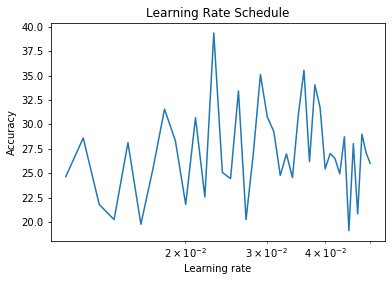

In [ ]:
lr_finder.plot(metric='acc', skip_start=10, skip_end=0)
lr_finder.reset()

In [ ]:
best_loss = lr_finder.best_loss
best_lr = lr_finder.history["lr"][lr_finder.history["loss"].index(best_loss)]
print("Best Accuracy: %s\nBest Learning Rate: %s" % (best_loss, best_lr))

Best Accuracy: 0.016617268908023834
Best Learning Rate: 0.026050552429667518


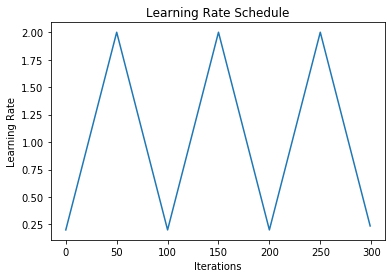

<Figure size 432x288 with 0 Axes>

In [ ]:
lrplt = LRCyclePlot({})
lrplt("lr_cycle_plot_test.png")

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = OneCycleLR(optimizer, max_lr=best_lr, steps_per_epoch=len(trainloader),
                       epochs=24, div_factor=5, final_div_factor=1,
                       pct_start=0.2, anneal_strategy="linear")

In [ ]:
clf = training_class(model = model,trainloader = trainloader, testloader = testloader, device = device, epoch= 24, optimizer = optimizer, criterion = criterion ,l1 = 0 , l2 = 0,scheduler=scheduler)
train_acc,test_acc = clf.fit()
model_f = clf.give_model()

epoch [0] train accuracy 0.734 : test accuracy 0.743
epoch [1] train accuracy 0.779 : test accuracy 0.773
epoch [2] train accuracy 0.829 : test accuracy 0.809
epoch [3] train accuracy 0.844 : test accuracy 0.823
epoch [4] train accuracy 0.839 : test accuracy 0.818
epoch [5] train accuracy 0.887 : test accuracy 0.858
epoch [6] train accuracy 0.890 : test accuracy 0.855
epoch [7] train accuracy 0.912 : test accuracy 0.872
epoch [8] train accuracy 0.905 : test accuracy 0.867
epoch [9] train accuracy 0.917 : test accuracy 0.877
epoch [10] train accuracy 0.917 : test accuracy 0.872
epoch [11] train accuracy 0.933 : test accuracy 0.879
epoch [12] train accuracy 0.935 : test accuracy 0.882
epoch [13] train accuracy 0.943 : test accuracy 0.887
epoch [14] train accuracy 0.933 : test accuracy 0.881
epoch [15] train accuracy 0.948 : test accuracy 0.893
epoch [16] train accuracy 0.947 : test accuracy 0.885
epoch [17] train accuracy 0.952 : test accuracy 0.889
epoch [18] train accuracy 0.959 : test

In [ ]:
torch.save(model_f, "model.sav")

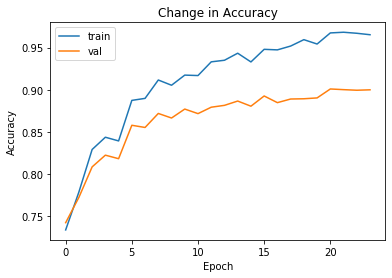

In [ ]:
plt_data = {
    "train": train_acc,
    "val": test_acc
}
plot_graph(plt_data, "Accuracy")

In [ ]:
##Test Loop
testloss,test_check =  truth_checker(model, testloader, device,criterion)

In [ ]:
print("Test Accuracy: %s\n" % (test_check))

Test Accuracy: 0.9

